In [1]:
import re
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
ia.seed(1)

batch_size = 128

In [2]:
def get_image_brightness(image):
    image_arr = np.array(bad_image, dtype=np.uint8)
    heigh, width, chanel = image_arr.shape
    image_arr_plain = image_arr.reshape(heigh * width, chanel)
    return image_arr_plain.sum(axis=0)[0] / (heigh * width * 255)

In [3]:
def increase_brightness(image, multiplier=1.2):
    seq = iaa.Sequential([iaa.Multiply(multiplier)])
    return seq.augment_images([image])[0]

In [4]:
images = np.array(
    [imageio.imread('just_number.jpg', pilmode="RGB") for _ in range(batch_size)],
    dtype=np.uint8
)

In [5]:
seq = iaa.SomeOf(2, [
    # random crops
#     iaa.Crop(percent=(0, 0.01)),
    
#     # Small blur
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0, 0.8)),
        iaa.AverageBlur(k=(0, 2)),
        iaa.MedianBlur(k=(1, 3)),
    ]),
    
#     # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    
#     # Add gaussian noise.
#     # For 50% of all images, we sample the noise once per pixel.
#     # For the other 50% of all images, we sample the noise per pixel AND
#     # channel. This can change the color (not only brightness) of the
#     # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    iaa.Add((-40, 40), per_channel=0.5),
#     iaa.Grayscale(alpha=1.0),
    
#     # Make some images brighter and some darker.
#     # In 20% of all cases, we sample the multiplier once per channel,
#     # which can end up changing the color of the images.
    iaa.Multiply((0.7, 1.3), per_channel=0.5),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
#         rotate=(-15, 15),
        shear=(-30, 30),
        mode='wrap'
    )
])

images_aug = seq.augment_images(images)

seq = iaa.Sequential([
    iaa.Grayscale(alpha=1.0),
    iaa.Crop(percent=0.01),
    iaa.Multiply(2.0)
])

images_aug = seq.augment_images(images_aug)

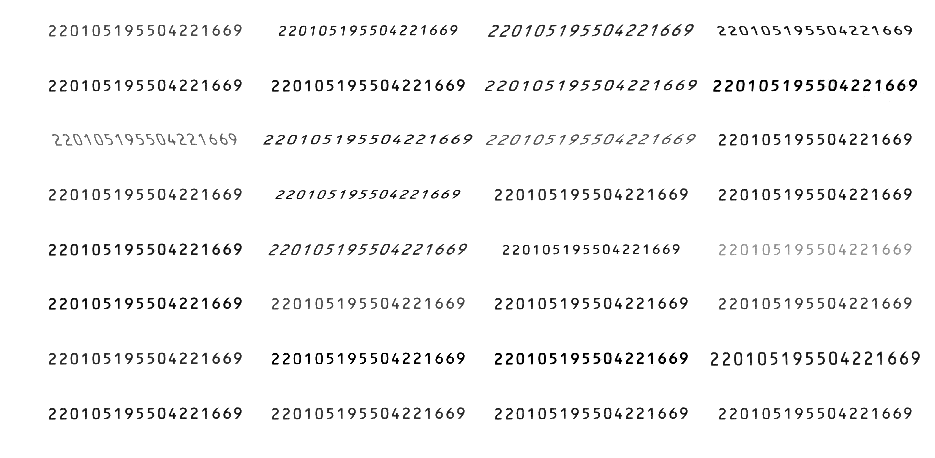

In [6]:
nrows = 8
ncols = 4
fig = plt.figure(figsize=(ncols*4, nrows))

for r in range(nrows):
    for c in range(ncols):
        i = c + r * ncols
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images_aug[i])
        plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()

In [34]:
brightness_lst = [get_image_brightness(im) for im in images_aug]
min(brightness_lst), max(brightness_lst) 

(0.9554490938675665, 0.9554490938675665)

In [7]:
import pytesseract
from PIL import Image
from difflib import SequenceMatcher

In [8]:
validate_val = '220105195504221669'

fails = 0
predict_vals = []
for i in range(batch_size):
    im = Image.fromarray(images_aug[i])
    predict_val = pytesseract.image_to_string(im, lang='eng')
    predict_val = predict_val.replace(' ', '')
    predict_vals.append(predict_val)

In [9]:
bad_vals = []
for i in range(batch_size):
    predict_val = predict_vals[i]
    if predict_val != validate_val:
        simalarity = SequenceMatcher(None, predict_val, validate_val).ratio()
        if simalarity < 0.8:
            if simalarity < 0.7:
                print(f'{predict_val:>20} - {simalarity:.1f} (simalarity) bad !!')
                bad_vals.append(i)
            else:
                print(f'{predict_val:>20} - {simalarity:.2f} (simalarity)')
        else:
            print(predict_val)
        fails += 1
        
print(f'accuracy: {(1 - fails / batch_size) * 100}')

22070579550422766%9
22017105795504227669
    VNNVDA955VLLN669 - 0.4 (simalarity) bad !!
2207057955042276692
  22070579550422766% - 0.78 (simalarity)
220705795504227669
  22070579550422766% - 0.78 (simalarity)
22070579550422766%9
220710579550422766%9
2201051955042669
2010519550422669
   TOONNHAHDNVLANGKY - 0.0 (simalarity) bad !!
 22070579550422766%2 - 0.76 (simalarity)
2201051955047221669
220105195504L22\669
2010519550422669
accuracy: 87.5


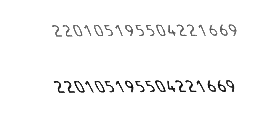

In [10]:
nrows = len(bad_vals)
ncols = 1
fig = plt.figure(figsize=(ncols*4, nrows))

for r in range(nrows):
    for c in range(ncols):
        i = c + r * ncols
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images_aug[bad_vals[r]])
        plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()

# add brightness for bad images

In [11]:
seq = iaa.Sequential([
    iaa.Multiply(1.6),
])

bad_images = [images_aug[i] for i in bad_vals]
bad_images_aug = seq.augment_images(bad_images)

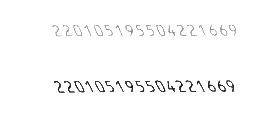

In [12]:
nrows = len(bad_images_aug)
ncols = 1
fig = plt.figure(figsize=(ncols*4, nrows))

for r in range(nrows):
    for c in range(ncols):
        i = c + r * ncols
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(bad_images_aug[i])
        plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()

In [13]:
fails_2 = 0
predict_vals = []
for i in range(len(bad_images_aug)):
    im = Image.fromarray(bad_images_aug[i])
    predict_val = pytesseract.image_to_string(im, lang='eng')
    predict_val = predict_val.replace(' ', '')
    predict_val = re.sub(r'\D', '', predict_val)
    predict_vals.append(predict_val)

In [14]:
bad_vals = []
for i in range(len(bad_images_aug)):
    predict_val = predict_vals[i]
    if predict_val != validate_val:
        simalarity = SequenceMatcher(None, predict_val, validate_val).ratio()
        if simalarity < 0.8:
            if simalarity < 0.7:
                print(f'{predict_val:>20} - {simalarity:.1f} (simalarity) bad !!')
                bad_vals.append(i)
            else:
                print(f'{predict_val:>20} - {simalarity:.2f} (simalarity)')
        else:
            print(predict_val)
        fails += 1
        
print(f'accuracy: {(1 - fails / batch_size) * 100}')

        295506422669 - 0.73 (simalarity)
                     - 0.0 (simalarity) bad !!
accuracy: 85.9375


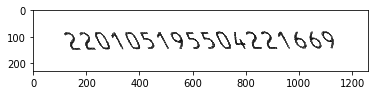

In [16]:
bad_image = bad_images_aug[1]
plt.imshow(bad_image)
plt.show()

In [17]:
bad_image_arr = np.array(bad_image, dtype=np.uint8)

In [18]:
heigh, width, chanel = bad_image_arr.shape

In [19]:
bad_image_arr_plain = bad_image_arr.reshape(heigh * width, chanel)

In [20]:
bad_image_arr_plain.sum(axis=0)[0] / (heigh * width * 255)

0.9554490938675665

In [21]:
def get_image_brightness(image):
    image_arr = np.array(bad_image, dtype=np.uint8)
    heigh, width, chanel = image_arr.shape
    image_arr_plain = image_arr.reshape(heigh * width, chanel)
    return image_arr_plain.sum(axis=0)[0] / (heigh * width * 255)

In [23]:
get_image_brightness(bad_images_aug[1])

0.9554490938675665

In [24]:
def increase_brightness(image, multiplier=1.2):
    seq = iaa.Sequential([iaa.Multiply(multiplier)])
    return seq.augment_images([image])[0]

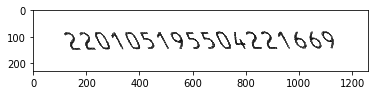

In [25]:
plt.imshow(bad_image)
plt.show()

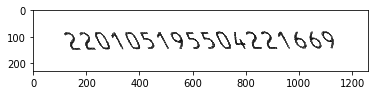

In [26]:
increase_brightness(bad_image, 1000)
plt.imshow(bad_image)
plt.show()

In [28]:
get_image_brightness(bad_images_aug[1])

0.9554490938675665